In [1]:
!pip install pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras
import keras.optimizers as optimizers
from keras import layers, callbacks
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
import pyreadr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import random

### PCA Class

In [174]:
class CreateModel:
    def __init__(self):
        pass

    def flatten(self, data):
        self.samples, self.timestamps, self.features = data.shape[0], data.shape[1], data.shape[2]
        return data.reshape(self.samples * self.timestamps, self.features)

    def reshape(self, data):
        return data.reshape(self.samples, self.timestamps, self.features)

    def normalize(self, data):
        scaler = MinMaxScaler()
        a = self.flatten(data)
        b = scaler.fit_transform(a)
        data = self.reshape(b)
        return data

    def fit_pca(self, data, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

        data = self.flatten(data)
        self.pca.fit(data)
        data_pca = self.pca.transform(data)
        data_rec = self.pca.inverse_transform(data_pca)
        data_rec = self.reshape(data_rec)
        return data_rec

    def evaluate_pca(self, n_data, n_data_rec, f_data):
        f_data = self.flatten(f_data)
        f_data_pca = self.pca.transform(f_data)
        self.f_data_rec = self.pca.inverse_transform(f_data_pca)
        self.f_data_rec = self.reshape(self.f_data_rec)
        f_data = self.reshape(f_data)

        self.pca_threshold = np.max(np.mean(np.abs(n_data - n_data_rec), axis=1))
        f_error = np.mean(np.abs(f_data - self.f_data_rec), axis=1)

        result = []
        for i in range(len(f_error)):
            anomalies = f_error[i,] > self.pca_threshold
            if np.sum(anomalies >= 1):
                result.append(1)
            else:
                result.append(0)
        return np.sum(np.array(result))

    def get_f_rec(self):
        return self.f_data_rec

    def fit_ae(self, data):
        self.model = keras.Sequential(
            [
                layers.Dense(128, input_shape=(data.shape[1], data.shape[2]), activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(data.shape[2])
            ]
        )
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
        self.model.summary()

        history = self.model.fit(
            data,
            data,
            epochs=50,
            batch_size=128,
            validation_split=0.1,
            verbose=2
        )

        predictions = self.model.predict(data)
        return predictions

    def evaluate_ae(self, n_data, n_data_rec, f_data):
        f_data_rec = self.model.predict(f_data)
        self.ae_threshold = np.max(np.mean(np.abs(n_data - n_data_rec), axis=1))
        f_error = np.mean(np.abs(f_data - self.f_data_rec), axis=1)

        result = []
        for i in range(len(f_error)):
            anomalies = f_error[i,] > self.pca_threshold
            if np.sum(anomalies >= 1):
                result.append(1)
            else:
                result.append(0)
        return np.sum(np.array(result))

    def plot(self, n_data, n_data_rec, f_data, f_data_rec, sample, feature):
        plt.figure(figsize=(12, 12))
        plt.subplot(211)
        plt.title(f"Normal Data Mean Absolute Error: {mae(n_data[sample][:, feature], n_data_rec[sample][:, feature])}")
        plt.plot(n_data[sample][:, feature])
        plt.plot(n_data_rec[sample][:, feature])
        plt.subplot(212)
        plt.title(f"Faulty Data Mean Absolute Error: {mae(f_data[sample][:, feature], f_data_rec[sample][:, feature])}")
        plt.plot(f_data[sample][:, feature])
        plt.plot(f_data_rec[sample][:, feature])
        plt.show()

#### Normal Data

In [103]:
class DataCreation:
    def __init__(self):
        pass

    def create_feature(self, function, mean, variance, co_ef, intercept, freq):
        x = co_ef * function(np.linspace(0, 50*np.pi, 1000)) + intercept
        x = x + np.random.normal(mean, variance, 1000)
        return x

    def create_samples(self, num_samples, features, seed):
        self.num_samples = num_samples
        self.features = features
        self.X = []

        for i in range(num_samples):
            d = {}
            random.seed(seed)
            for j in range(features):

                #freq = random.uniform(10, 50)
                co_ef = random.randint(1, 10)
                intercept = random.uniform(0, 500)
                mean = 0
                variance = random.uniform(0.1, 2)
                function = random.choice([np.sin, np.cos])

                d[f'x_{j}'] = self.create_feature(function, mean, variance, co_ef, intercept, 0)
            training = pd.DataFrame(d)
            self.X.append(training)
        self.X = np.array(self.X)
        return self.X

    def plot_feature(self, data, sample, feature):
        plt.figure(figsize=(12, 6))
        plt.plot(data[sample][:,feature])
        plt.show()
        pass

In [172]:
n_data = DataCreation()
n_train_X = n_data.create_samples(1000, 50, 2)
n_train_X.shape

(1000, 1000, 50)

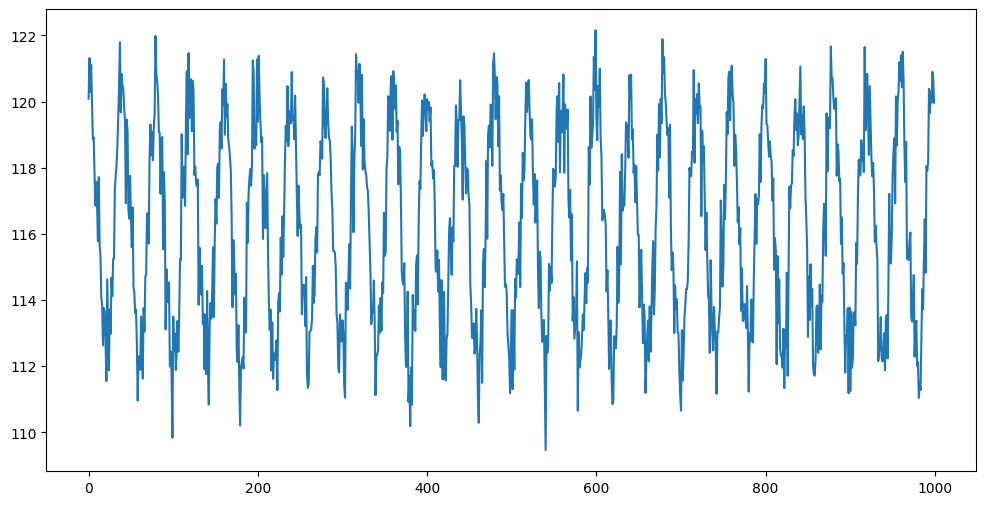

In [105]:
n_data.plot_feature(n_train_X, 0, 40)

#### Faulty Data: Point Anomaly

In [106]:
f_data = DataCreation()
f_train_X = f_data.create_samples(1000, 50, 2)
f_train_X.shape

(1000, 1000, 50)

In [107]:
random.seed(1000)
for i in range(1000):
    rand_feature = random.choice([i for i in range(50)])
    rand_timestamp = random.choice([i for i in range(1000)])
    f_train_X[i][rand_timestamp, rand_feature] = np.mean(f_train_X[i][:,rand_feature]) + 3*np.std(f_train_X[i][:,rand_feature])

In [108]:
random.seed(1000)
print(random.choice([i for i in range(50)]), random.choice([i for i in range(1000)]))

49 439


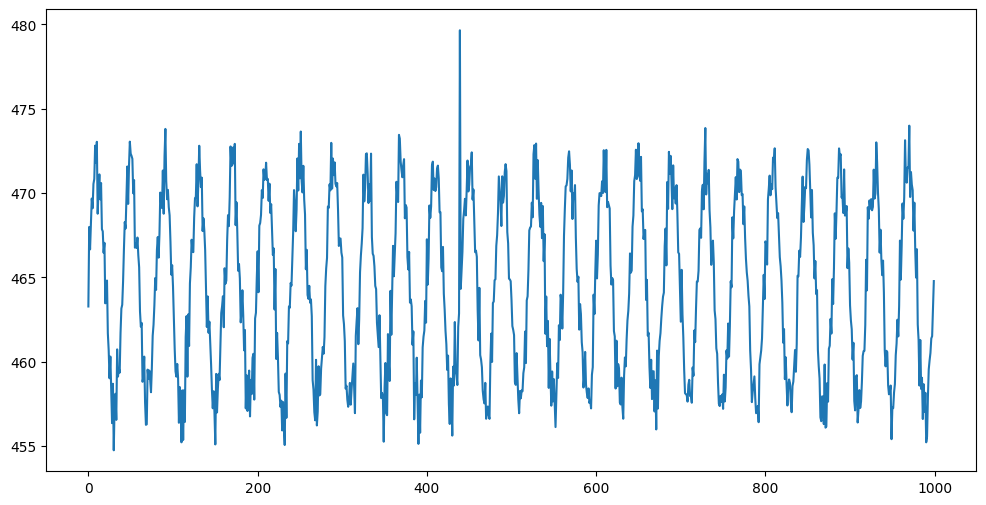

In [109]:
f_data.plot_feature(f_train_X, 0, 49)

In [110]:
pca = CreateModel()
n_train_X, f_train_X = pca.normalize(n_train_X), pca.normalize(f_train_X)
n_train_rec = pca.fit_pca(n_train_X, 5)
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, f_train_X)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: 0.07006097921009713
Total Anomalies out of 1000: 1000


In [176]:
ae = CreateModel()
n_train_X, f_train_X = ae.normalize(n_train_X), ae.normalize(f_train_X)
n_train_rec = ae.fit_ae(n_train_X)
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, f_train_X)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1000, 128)         6528      
                                                                 
 dense_7 (Dense)             (None, 1000, 64)          8256      
                                                                 
 dense_8 (Dense)             (None, 1000, 32)          2080      
                                                                 
 dense_9 (Dense)             (None, 1000, 64)          2112      
                                                                 
 dense_10 (Dense)            (None, 1000, 128)         8320      
                                                                 
 dense_11 (Dense)            (None, 1000, 50)          6450      
                                                                 
Total params: 33746 (131.82 KB)
Trainable params: 3374

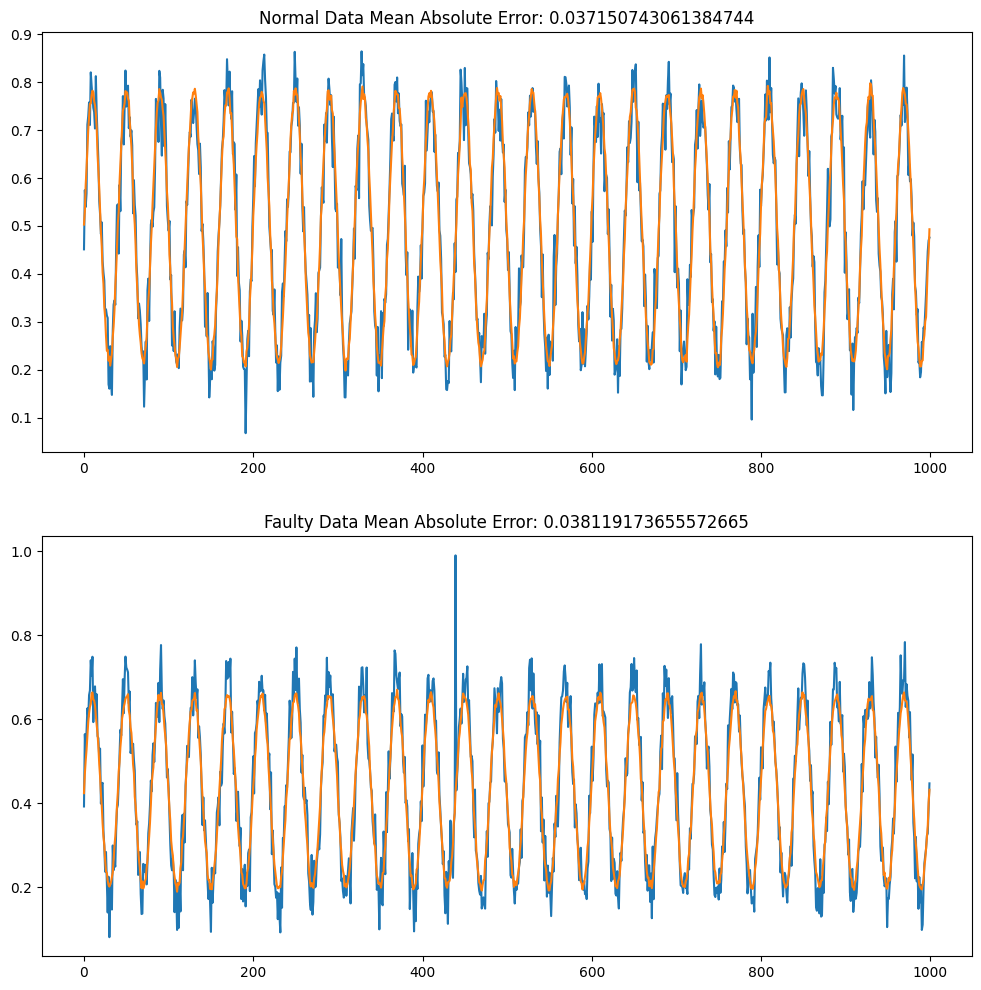

In [111]:
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 0, 49)

#### Faulty Data: Collective Anomalies

In [119]:
n_data = DataCreation()
n_train_X = n_data.create_samples(1000, 50, 2)
f_data = DataCreation()
f_train_X = f_data.create_samples(1000, 50, 2)
f_train_X.shape

(1000, 1000, 50)

In [120]:
random.seed(1001)
for i in range(1000):
    rand_feature = random.choice([i for i in range(50)])
    rand_timestamp = random.choice([i for i in range(1000)])
    f_train_X[i][rand_timestamp:rand_timestamp+20, rand_feature] = f_train_X[i][rand_timestamp, rand_feature]

In [121]:
random.seed(1001)
print(random.choice([i for i in range(50)]), random.choice([i for i in range(1000)]))

3 778


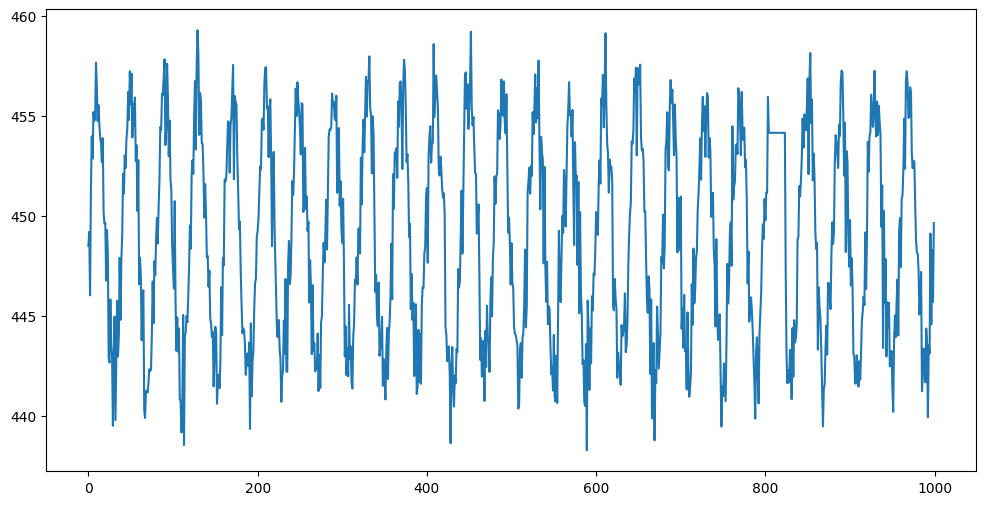

In [122]:
f_data.plot_feature(f_train_X, 3, 24)

In [123]:
pca = CreateModel()
n_train_X, f_train_X = pca.normalize(n_train_X), pca.normalize(f_train_X)
n_train_rec = pca.fit_pca(n_train_X, 5)
anomalies = pca.evaluate(n_train_X, n_train_rec, f_train_X)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: 0.06938570169308043
Total Anomalies out of 1000: 4


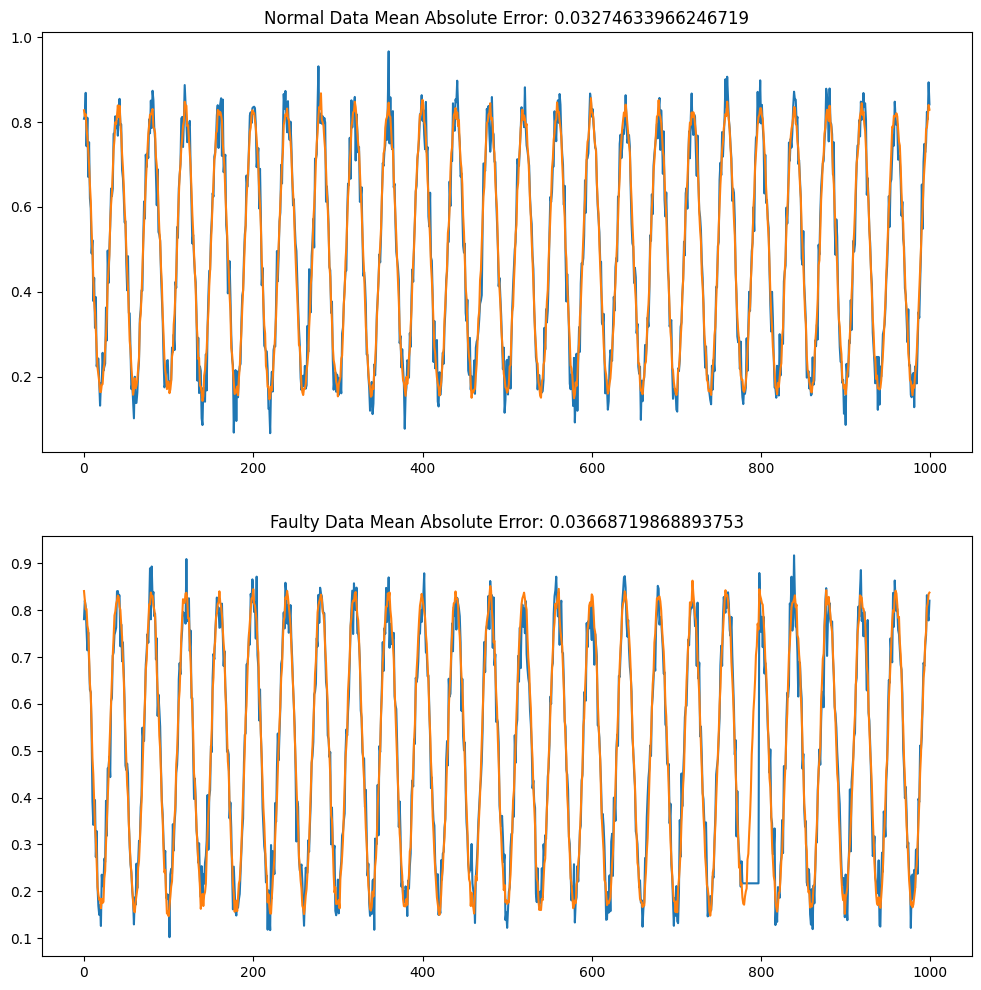

In [124]:
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 0, 3)

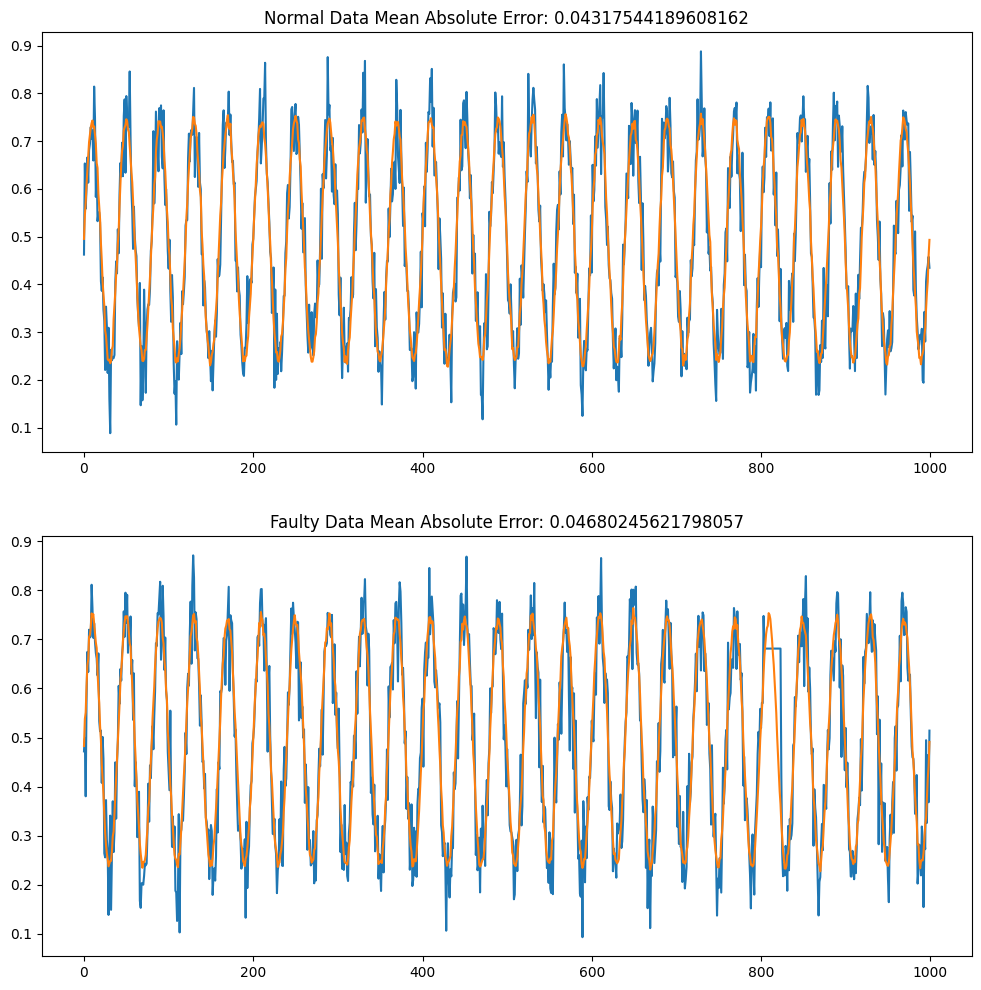

In [125]:
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 3, 24)

#### Faulty Data: Contextual Anomaly

In [ ]:
n_data = DataCreation()
n_train_X = n_data.create_samples(1000, 50, 2)
f_data = DataCreation()
f_train_X = f_data.create_samples(1000, 50, 2)
f_train_X.shape

(1000, 1000, 50)

In [158]:
# Choose 2 random features

random.seed(1002)
a = [i for i in range(50)]
feature_1 = random.choice(a)
a.remove(feature_1)
feature_2 = random.choice(a)

In [159]:
# Properties of function for features

co_ef_1 = random.randint(1, 10)
intercept_1 = random.uniform(0, 500)
mean = 0
variance_1 = random.uniform(0.05, 0.1)

co_ef_2 = random.randint(1, 10)
intercept_2 = random.uniform(0, 500)
variance_2 = random.uniform(0.05, 1)

Normal Data

In [168]:
for i in range(pca.samples):
    b = np.array([intercept_1 for i in range(1000)], dtype=object)
    c = np.array([intercept_2 for i in range(1000)], dtype=object)
    ts_1 = random.choice([i for i in range(200, 800)])
    ts_2 = random.choice([i for i in range(ts_1-150)])
    index_1 = [i for i in range(ts_1, ts_1+150)]
    index_2 = [i for i in range(ts_2, ts_2+150)]
    index_3 = [i for i in range(ts_1-40, ts_1)]
    index_4 = [i for i in range(ts_2-40, ts_2)]
    b[index_1] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    b[index_2] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    c[index_3] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    c[index_4] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    b = b + np.random.normal(mean, variance_1, 1000)
    c = c + np.random.normal(mean, variance_2, 1000)
    n_train_X[i][:, feature_1] = b
    n_train_X[i][:, feature_2] = c

Faulty Data

In [ ]:
for i in range(pca.samples):
    b = np.array([intercept_1 for i in range(1000)], dtype=object)
    c = np.array([intercept_2 for i in range(1000)], dtype=object)
    ts_1 = random.choice([i for i in range(200, 800)])
    ts_2 = random.choice([i for i in range(ts_1-150)])
    index_1 = [i for i in range(ts_1, ts_1+150)]
    index_2 = [i for i in range(ts_2, ts_2+150)]
    index_3 = [i for i in range(ts_1-40, ts_1)]
    index_4 = [i for i in range(ts_2-40, ts_2)]
    b[index_1] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    b[index_2] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    c[index_3] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    c[index_4] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    b = b + np.random.normal(mean, variance_1, 1000)
    c = c + np.random.normal(mean, variance_2, 1000)

    f_train_X[i][:, feature_1] = b
    f_train_X[i][:, feature_2] = c

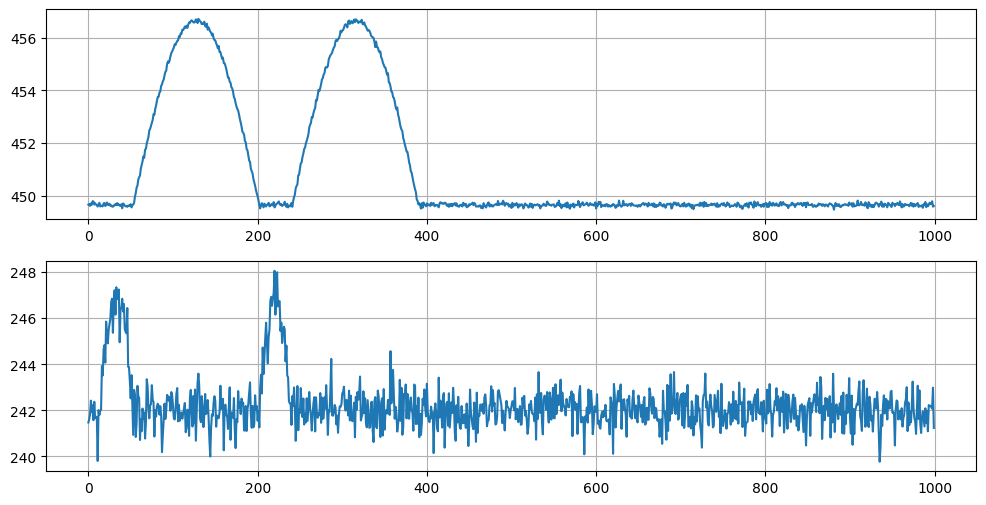

In [171]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(n_train_X[2][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(n_train_X[2][:, feature_2])
plt.grid(True)
plt.show()